# YOLO 输出

In [1]:
import set_env
from d2py.utils.file import mkdir
root_dir = ".temp"
mkdir(f"{root_dir}/logs") 

In [2]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.onnx import OperatorExportTypes, utils

In [3]:
def autopad(k, p=None, d=1):  # kernel, padding, dilation
    """Pad to 'same' shape outputs."""
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


class Conv(nn.Module):
    """Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)."""
    # default_act = nn.SiLU()  # default activation
    default_act = nn.ReLU()
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        """Initialize Conv layer with given arguments including activation."""
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        """Apply convolution, batch normalization and activation to input tensor."""
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        """Perform transposed convolution of 2D data."""
        return self.act(self.conv(x))

In [4]:
class DFL(nn.Module):
    """
    Integral module of Distribution Focal Loss (DFL).
    Proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    """

    def __init__(self, c1=16):
        """Initialize a convolutional layer with a given number of input channels."""
        super().__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        """Applies a transformer layer on input tensor 'x' and returns a tensor."""
        b, c, a = x.shape  # batch, channels, anchors
        # return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(b, 4, a)
        return self.conv(x.view(b, self.c1, 4, a).softmax(1)).view(b, 4, a)

In [5]:
def make_anchors(feats, strides, grid_cell_offset=0.5):
    """Generate anchors from features."""
    anchor_points, stride_tensor = [], []
    assert feats is not None
    # for ff in feats:
    #     print(f"make_anchors: {ff.shape}")
    dtype, device = feats[0].dtype, feats[0].device
    for i, stride in enumerate(strides):
        _, _, h, w = feats[i].shape
        print(f"stride, h, w: {stride, h, w}")
        sx = torch.arange(end=w, device=device, dtype=dtype) + grid_cell_offset  # shift x
        sy = torch.arange(end=h, device=device, dtype=dtype) + grid_cell_offset  # shift y
        sy, sx = torch.meshgrid(sy, sx, indexing='ij')
        anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
        stride_tensor.append(torch.full((h * w, 1), stride, dtype=dtype, device=device))
    return torch.cat(anchor_points), torch.cat(stride_tensor)

In [6]:
def dist2bbox(distance, anchor_points, xywh=True, dim=-1):
    """Transform distance(ltrb) to box(xywh or xyxy)."""
    lt, rb = distance.chunk(2, dim)
    x1y1 = anchor_points - lt
    x2y2 = anchor_points + rb
    if xywh:
        c_xy = (x1y1 + x2y2) / 2
        wh = x2y2 - x1y1
        return torch.cat((c_xy, wh), dim)  # xywh bbox
    return torch.cat((x1y1, x2y2), dim)  # xyxy bbox

In [7]:
class Detect(nn.Module):
    """YOLOv8 Detect head for detection models."""
    dynamic = False  # force grid reconstruction
    export = False  # export mode
    shape = None
    anchors = torch.empty(0)  # init
    strides = torch.empty(0)  # init

    def __init__(self, nc=80, ch=()):  # detection layer
        super().__init__()
        self.nc = nc  # number of classes
        self.nl = len(ch)  # number of detection layers
        self.reg_max = 16  # DFL channels (ch[0] // 16 to scale 4/8/12/16/20 for n/s/m/l/x)
        self.no = nc + self.reg_max * 4  # number of outputs per anchor
        self.stride = torch.tensor([8., 16., 32.]) #torch.zeros(self.nl)  # strides computed during build
        c2, c3 = max((16, ch[0] // 4, self.reg_max * 4)), max(ch[0], min(self.nc, 100))  # channels
        self.cv2 = nn.ModuleList(
            nn.Sequential(Conv(x, c2, 3), Conv(c2, c2, 3), nn.Conv2d(c2, 4 * self.reg_max, 1)) for x in ch)
        self.cv3 = nn.ModuleList(nn.Sequential(Conv(x, c3, 3), Conv(c3, c3, 3), nn.Conv2d(c3, self.nc, 1)) for x in ch)
        self.dfl = DFL(self.reg_max) if self.reg_max > 1 else nn.Identity()

    def forward(self, x):
        """Concatenates and returns predicted bounding boxes and class probabilities."""
        shape = x[0].shape  # BCHW
        for i in range(self.nl):
            x[i] = torch.cat((self.cv2[i](x[i]), self.cv3[i](x[i])), 1)
        if self.training:
            return x
        elif self.dynamic or self.shape != shape:
            print(f"Detect: {self.stride}")
            self.anchors, self.strides = (x.transpose(0, 1) for x in make_anchors(x, self.stride, 0.5))
            self.shape = shape

        x_cat = torch.cat([xi.view(shape[0], self.no, -1) for xi in x], 2)
        if self.export and self.format in ('saved_model', 'pb', 'tflite', 'edgetpu', 'tfjs'):  # avoid TF FlexSplitV ops
            box = x_cat[:, :self.reg_max * 4]
            cls = x_cat[:, self.reg_max * 4:]
        else:
            box, cls = x_cat.split((self.reg_max * 4, self.nc), 1)
        dbox = dist2bbox(self.dfl(box), self.anchors.unsqueeze(0), xywh=True, dim=1) * self.strides

        if self.export and self.format in ('tflite', 'edgetpu'):
            # Normalize xywh with image size to mitigate quantization error of TFLite integer models as done in YOLOv5:
            # https://github.com/ultralytics/yolov5/blob/0c8de3fca4a702f8ff5c435e67f378d1fce70243/models/tf.py#L307-L309
            # See this PR for details: https://github.com/ultralytics/ultralytics/pull/1695
            img_h = shape[2] * self.stride[0]
            img_w = shape[3] * self.stride[0]
            img_size = torch.tensor([img_w, img_h, img_w, img_h], device=dbox.device).reshape(1, 4, 1)
            dbox /= img_size

        y = torch.cat((dbox, cls.sigmoid()), 1)
        return y
        # return y if self.export else (y, x)

In [8]:
class M(nn.Module):
    def __init__(self, nc=80, ch=(16, 256, 1024)):  # detection layer
        super().__init__()
        self.conv0 = nn.Conv2d(3, 16, 1, 1, groups=1, bias=False)
        self.conv1 = nn.Conv2d(16, ch[0], 1, 1, groups=1, bias=False)
        self.conv2 = nn.Conv2d(16, ch[1], 1, 2, groups=1, bias=False)
        self.conv3 = nn.Conv2d(16, ch[2], 1, 4, groups=1, bias=False)
        self.det = Detect(nc=nc, ch=ch)

    def forward(self, x):
        x = self.conv0(x)
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x = self.det([x1, x2, x3])
        return x

In [9]:
model = M().eval()

shape = 1, 3, 48, 80
xx = torch.rand(*shape, dtype=torch.float32, requires_grad=False)
# model = torch.jit.trace(model, xx)
# 导出模型
input_name = "data"
output_name = "yolo"
utils.export(
    model,               # torch 模型
    xx,                         # 模型输入或者对于多个输入，使用元组
    f"{root_dir}/{output_name}.onnx",               # 模型保存的位置（可以是文件或类似文件的对象）
    export_params=True,        # 将训练后的参数权重存储在模型文件内
    opset_version=17,          # 导出模型的 ONNX 版本
    do_constant_folding=True,  # 是否执行常量折叠以进行优化
    input_names = [input_name],    # 模型的输入名称
    output_names = ['output'], # 模型的输出名称
    keep_initializers_as_inputs=True,
    # export_modules_as_functions=True,
    verbose=True,
    operator_export_type=OperatorExportTypes.ONNX_FALLTHROUGH,
    # dynamic_axes={'data' : {0 : 'batch_size'},    # 可变长度的轴
    #               'output' : {0 : 'batch_size'}}
)

Detect: tensor([ 8., 16., 32.])
stride, h, w: (tensor(8.), tensor(48), tensor(80))
stride, h, w: (tensor(16.), tensor(24), tensor(40))
stride, h, w: (tensor(32.), tensor(12), tensor(20))


/tmp/ipykernel_2640477/2190579285.py:8: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for i, stride in enumerate(strides):


Exported graph: graph(%data : Float(1, 3, 48, 80, strides=[11520, 3840, 80, 1], requires_grad=0, device=cpu),
      %conv0.weight : Float(16, 3, 1, 1, strides=[3, 1, 1, 1], requires_grad=1, device=cpu),
      %conv1.weight : Float(16, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=cpu),
      %conv2.weight : Float(256, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=cpu),
      %conv3.weight : Float(1024, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=cpu),
      %det.cv2.0.2.weight : Float(64, 64, 1, 1, strides=[64, 1, 1, 1], requires_grad=1, device=cpu),
      %det.cv2.0.2.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %det.cv2.1.2.weight : Float(64, 64, 1, 1, strides=[64, 1, 1, 1], requires_grad=1, device=cpu),
      %det.cv2.1.2.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %det.cv2.2.2.weight : Float(64, 64, 1, 1, strides=[64, 1, 1, 1], requires_grad=1, device=cpu),
      %det.cv2.2.2.bias : Float(64, strides=[1],

In [10]:
import onnx
import tvm
from tvm import relay
onnx_model = onnx.load(f"{root_dir}/{output_name}.onnx")
mod, params = relay.frontend.from_onnx(onnx_model, {"data": shape}, freeze_params=True)
mod = relay.transform.InferType()(mod)
# with tvm.transform.PassContext(opt_level=3):
#     mod = relay.quantize.prerequisite_optimize(mod, params)
# mod.show()

In [11]:
print(mod)

def @main(%data: Tensor[(1, 3, 48, 80), float32] /* ty=Tensor[(1, 3, 48, 80), float32] span=/conv0/Conv.data:0:0 */) -> Tensor[(1, 84, 5040), float32] {
  %0 = nn.conv2d(%data, meta[relay.Constant][1] /* ty=Tensor[(16, 3, 1, 1), float32] span=/conv0/Conv.conv0.weight:0:0 */, padding=[0, 0, 0, 0], channels=16, kernel_size=[1, 1]) /* ty=Tensor[(1, 16, 48, 80), float32] span=/conv0/Conv:0:0 */;
  %1 = nn.conv2d(%0, meta[relay.Constant][2] /* ty=Tensor[(16, 16, 1, 1), float32] span=/conv1/Conv.conv1.weight:0:0 */, padding=[0, 0, 0, 0], channels=16, kernel_size=[1, 1]) /* ty=Tensor[(1, 16, 48, 80), float32] span=/conv1/Conv:0:0 */;
  %2 = nn.conv2d(%1, meta[relay.Constant][3] /* ty=Tensor[(64, 16, 3, 3), float32] span=/det/cv2.0/cv2.0.0/conv/Conv.onnx::Conv_296:0:0 */, padding=[1, 1, 1, 1], channels=64, kernel_size=[3, 3]) /* ty=Tensor[(1, 64, 48, 80), float32] span=/det/cv2.0/cv2.0.0/conv/Conv:0:0 */;
  %3 = nn.bias_add(%2, meta[relay.Constant][4] /* ty=Tensor[(64), float32] span=/det/cv2.

In [12]:
from tvm.relay.dataflow_pattern import rewrite

In [13]:
from tvm.relay.analysis import extract_intermdeiate_expr
from yolo_dfl import DFLV1Rewrite, DFLV2Rewrite, DFLV3Rewrite
from yolo_dist2bbox import Dist2BBoxRewrite
from yolo_concat_split import VTAYoloOutputConcatSplitRewrite
from yolo_concat_split_concat import VTAYoloOutputConcatSplitConcatRewrite
onnx_model = onnx.load(f"{root_dir}/{output_name}.onnx")
mod, params = relay.frontend.from_onnx(onnx_model, {"data": shape}, freeze_params=True)
mod = relay.transform.InferType()(mod)

with tvm.transform.PassContext(opt_level=3):
    # 融合 concatenate+resahpe+concatenate+split
    mod["main"] = rewrite(VTAYoloOutputConcatSplitRewrite(), mod["main"])
    mod = relay.transform.InferType()(mod)
    # 简化 DFL 结构
    mod["main"] = rewrite(DFLV1Rewrite(), mod["main"])
    mod = relay.transform.InferType()(mod)
    mod["main"] = rewrite(DFLV2Rewrite(), mod["main"])
    mod = relay.transform.InferType()(mod)
    mod["main"] = rewrite(DFLV3Rewrite(), mod["main"])
    mod = relay.transform.InferType()(mod)
    # 融合 Dist2BBox
    mod["main"] = rewrite(Dist2BBoxRewrite(), mod["main"])
    mod = relay.transform.InferType()(mod)
    # 融合 Yolo 输出节点 concat+split+concat
    mod["main"] = rewrite(VTAYoloOutputConcatSplitConcatRewrite(), mod["main"])
    mod = relay.transform.InferType()(mod)

In [14]:
mod.show()

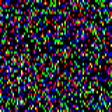

In [15]:
from PIL import Image
import numpy as np

image = np.random.normal(0, 1, size=(48, 80, 3)).astype("uint8")
mean = (128,)
std = (256,)
data = (image - mean)/std
data = data.transpose((2, 0, 1))
data = np.expand_dims(data, 0).astype("float32")
images = np.expand_dims(image, 0)
images.tofile(f"{root_dir}/input.bin")
Image.fromarray(image).resize((112, 112))

In [16]:
from dataclasses import dataclass

@dataclass
class Dataset:
    input_name: str
    shape: tuple

    def __iter__(self):
        for _ in range(2):
            yield {self.input_name: data}
        # for _ in range(50):
        #     yield {self.input_name: np.random.normal(0, 1, size=self.shape).astype("float32")}

dataset = Dataset(input_name, shape)
with tvm.transform.PassContext(opt_level=3):
    with relay.quantize.qconfig(
        skip_conv_layers=[],
        calibrate_mode="kl_divergence", 
        weight_scale="max",
        # round_for_shift=True,
        # rounding="TONEAREST", # "UPWARD" or "TONEAREST"
        skip_dense_layer=False,
    ): 
        qmod = relay.quantize.quantize(mod, params=params, dataset=dataset)

In [17]:
qmod.show()

In [18]:
# from tvm.relay.testing import run_infer_type
# from common.configs.vta_utils import vta_compile
# from vta import export_forXM
# # mean, std = params_revise(config.mean, config.std)
# target = "VTA2.0"
# if target == "VTA2.0":
#     board_target = "xmfpga_680v200"
# elif target == "sim":
#     board_target = "xmfpga_v500"
# else:
#     raise(f"暂未支持 {target}")
# # 编译模型
# lib = vta_compile(
#     qmod=qmod, 
#     params=params, 
#     target=board_target,
#     mean=(0,),
#     std=(1,),
#     input_name="data",
#     debug_flag=0,
#     prepare_flag=False
# )
# graph_pack = lib.ir_mod["main"]
# graph_pack = run_infer_type(graph_pack)